# Newton 2nd Law

### **Introduction**
Newton's Second Law of Motion is one of the most important principles in physics, explaining how the motion of an object changes when it is subjected to a force. This law provides a relationship between the force applied to an object, its mass, and its acceleration. It is often summarized by the equation:
$F_{net} = m\vec{a}$

Where:
* F is the total force applied to the object (measured in newtons, N),
* m is the mass of the object (measured in kilograms, kg),
* a is the acceleration produced (measured in meters per second squared, m/s²).

This law tells us that the force required to accelerate an object depends on two factors: how heavy the object is (its mass) and how much acceleration you want to produce.


### **What is it?**
Newton’s Second Law states that the acceleration of an object is directly proportional to the net force acting on it and inversely proportional to its mass. This means that for a given amount of force, a more massive object will accelerate less than a less massive object. Conversely, if the mass is constant, a larger force will produce a greater acceleration.

In essence, this law quantifies how forces affect the motion of objects. It explains why it's easier to push an empty shopping cart than a full one, and why a car requires a larger force to accelerate than a bicycle.


### **Example**
One simple example of Newton’s Second Law in action is a person pushing a sled across a snow-covered field. If the person applies a certain force, the sled will accelerate based on its mass. If the sled is light, it will accelerate quickly with just a small amount of force. But if the sled is loaded with heavy cargo, the same force will cause it to accelerate more slowly because its mass has increased.

Another example is when you drive a car. If you press the accelerator pedal (applying force), the car will accelerate. However, the acceleration depends on the car's mass—if you're driving a small, lightweight car, it will accelerate faster than a large, heavy truck with the same amount of force applied. The truck requires a greater force to achieve the same acceleration as the lighter car.

Newton's Second Law also explains the concept of momentum, which is directly tied to the mass and velocity of an object. This law is crucial for understanding how forces influence the motion of objects in everyday life, from simple actions like walking to complex phenomena like rocket launches.


# Simulation

### Installing packages (for Google Colab)

If this notebook is opened in Google Colab then some packages must be installed to run the code!

In [1]:
#@title Run to install MuJoCo and `dm_control` for Google Colab

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    print('Installing dm_control...')
    !pip install -q dm_control>=1.0.22

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl 

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    !echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy

    !git clone https://github.com/commanderxa/extraphi.git

## Import

Import all required packages to preform simulations. Packages include simulation engine, plotting libraries and other ones necessary for computations.

In [2]:
%env MUJOCO_GL=egl

import os

# simulation
from dm_control import mjcf

# for video recording
import mediapy

# computations
import numpy as np

# plot charts
import seaborn as sns
import matplotlib.pyplot as plt

env: MUJOCO_GL=egl


Set nice theme for plots

In [3]:
sns.set_theme(style="whitegrid")

## Initial Conditions

In this block constants are defined. They impact the environment, rendering and objects directly.

In [4]:
# global
viscosity = 0.00002  # Air Resistance

# simulation constants
box_mass = 1  # mass [kg]
ball_mass = 1  # mass [kg]
a = 20  # acceleration [m/s^2]
distance = 10  # platform length [m]

# rendering
width = 1280
height = 720
dpi = 600
duration = 30  # (seconds)
framerate = 60  # (Hz)

# project related
unit = os.getcwd().split("/")[-1]  # get the current directory
section = os.getcwd().split("/")[-2]  # get the current directory

## Model

### Scene

Import scene from `mechanics/scene.py`. The code is a bit difficult due to the import from parent directories.

In [5]:
import os, sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from scene import Scene

### Objects of Interest

This class defines the object of our interest, a `box`. Here we write what is this object (box), what can it do (move, fall) and also add a camera that follows the object.

In [6]:
class Sphere(object):

    def __init__(self, size: float, mass: float, camera: bool = True) -> None:
        self.model = mjcf.RootElement(model="sphere")

        self.sphere = self.model.worldbody.add("body", name="sphere", pos=[0, 0, 0])
        self.sphere_geom = self.sphere.add(
            "geom",
            name="sphere_geom",
            type="sphere",
            size=[size],
            rgba=[1, 0, 0, 1],
            mass=mass,
            condim=1,
        )

        # self.rotate = self.sphere.add(
        #     "joint", name="rotate", type="hinge", axis=[0, 1, 0], damping=0.1
        # )
        self.move = self.sphere.add(
            "joint", name="move", type="slide", axis=[1, 0, 0], damping=0.1
        )
        self.fall = self.sphere.add(
            "joint", name="fall", type="slide", axis=[0, 0, 1], damping=0.1
        )

        self.motor = self.model.actuator.add("motor", name="motor", joint=self.move)

        if camera:
            self.camera = self.sphere.add(
                "camera",
                name="front",
                pos=[0, -2.5, 0.2],
                euler=[90, 0, 0],
                mode="track",
            )


class Box(object):

    def __init__(self, name: str, mass: float, size: float) -> None:
        self.model = mjcf.RootElement(model=name)

        self.box = self.model.worldbody.add("body", name="box", pos=[0, 0, 0])
        self.box_geom = self.box.add(
            "geom",
            name="box_geom",
            type="box",
            size=[size, size, size],
            rgba=[0.1, 0.1, 0.5, 1],
            mass=mass,
        )
        self.move = self.box.add(
            "joint", name="move", type="slide", axis=[1, 0, 0], damping=0.1
        )
        self.fall = self.box.add(
            "joint", name="fall", type="slide", axis=[0, 0, 1], damping=0.1
        )

### World Model

Collecting everything into one general model

In [7]:
class Model(object):

    def __init__(self, distance: float) -> None:
        self.model = mjcf.RootElement(model="model")

        # set render info
        self.model.visual.__getattr__("global").offheight = height
        self.model.visual.__getattr__("global").offwidth = width

        # set the simulation constants
        self.model.option.viscosity = viscosity
        self.model.option.integrator = "RK4"
        self.model.option.timestep = 0.001

        self.sphere_size = 0.2
        self.box_size = 0.4

        # create the scene (ground)
        self.scene = Scene(length=distance, width=4)
        self.scene_site = self.model.worldbody.add(
            "site", pos=[distance / 2 - self.sphere_size * 3, 0, 0]
        )
        self.scene_site.attach(self.scene.model)

        # add sphere
        self.sphere = Sphere(size=self.sphere_size, mass=ball_mass)
        sphere_site = self.model.worldbody.add("site", pos=[0, 0, self.sphere_size])
        sphere_site.attach(self.sphere.model)

        # # add box
        # self.box = Box(name="box", size=self.box_size, mass=box_mass)
        # box_site = self.model.worldbody.add(
        #     "site",
        #     pos=[
        #         self.sphere_size + 2 * self.box_size,
        #         0,
        #         self.box_size,
        #     ],
        # )
        # box_site.attach(self.box.model)

        # add block
        self.block = Box(name="block", size=1, mass=1000)
        block_site = self.model.worldbody.add(
            "site", pos=[distance - self.sphere_size * 3, 0, 1], euler=[0, 0, 90]
        )
        block_site.attach(self.block.model)

## Simulation

Initializing the `physics` of the simulation

In [8]:
model = Model(distance).model
physics = mjcf.Physics.from_mjcf_model(model)

First of all, the environment must be verified by rendering a picture

""

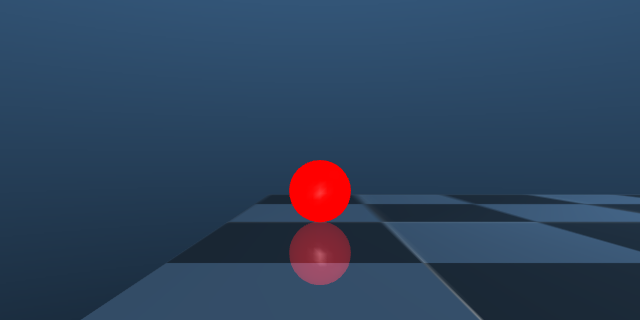

In [9]:
mediapy.show_image(physics.render(height=320, width=640, camera_id=0))

In [10]:
mediapy.write_image("../../output/newtons_2nd_law_preview.png", physics.render(height=720, width=1280, camera_id=0))

Calculate the force of the ball

In [11]:
force = ball_mass * a

Get IDs of interesting objects

In [12]:
sphere_id = physics.model.name2id("sphere/sphere_geom", "geom")
# box_id = physics.model.name2id("box/box_geom", "geom")
block_id = physics.model.name2id("block/box_geom", "geom")
sphere_id, block_id

(1, 2)

### Simulation Loop

In [13]:
frames = []
timevals = []
velocity = []
position = []

stop = None
while physics.data.time < duration:
    physics.step()

    if physics.data.time > 1:
        # apply the force
        physics.named.data.xfrc_applied["sphere/sphere", 0] = force

    if stop is not None and physics.data.time - stop > 1:
        break

    for i, c in enumerate(physics.data.contact):
        if sphere_id in c.geom and block_id in c.geom and stop is None:
            stop = physics.data.time

    timevals.append(physics.data.time)
    velocity.append(physics.named.data.qvel["sphere/move"][0].copy())
    position.append(physics.named.data.geom_xpos["sphere/sphere_geom"][0].copy())

    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(width=width, height=height, camera_id=0)
        frames.append(pixels)

This is how to see the manual forces (forces that we apply) acting on the objects

In [14]:
physics.named.data.xfrc_applied

FieldIndexer(xfrc_applied):
0         world [ 0         0         0         0         0         0       ]
1        scene/ [ 0         0         0         0         0         0       ]
2       sphere/ [ 0         0         0         0         0         0       ]
3 sphere/sphere [ 20        0         0         0         0         0       ]
4        block/ [ 0         0         0         0         0         0       ]
5     block/box [ 0         0         0         0         0         0       ]

In [15]:
mediapy.show_video(frames, fps=framerate)

In [16]:
# mediapy.write_video(f"../../output/newton_law_2.mp4", images=frames, fps=framerate)

## Simulation Data Visualization

Convert data into numpy array to have more features

In [17]:
velocity = np.array(velocity)
position = np.array(position)

In [18]:
velocity = velocity[:velocity.argmax().item()]
timevals_v = timevals[:len(velocity)]

position = position[:position.argmax().item()]
timevals_p = timevals[:len(position)]

In [19]:
len(velocity), len(timevals_v)

(1918, 1918)

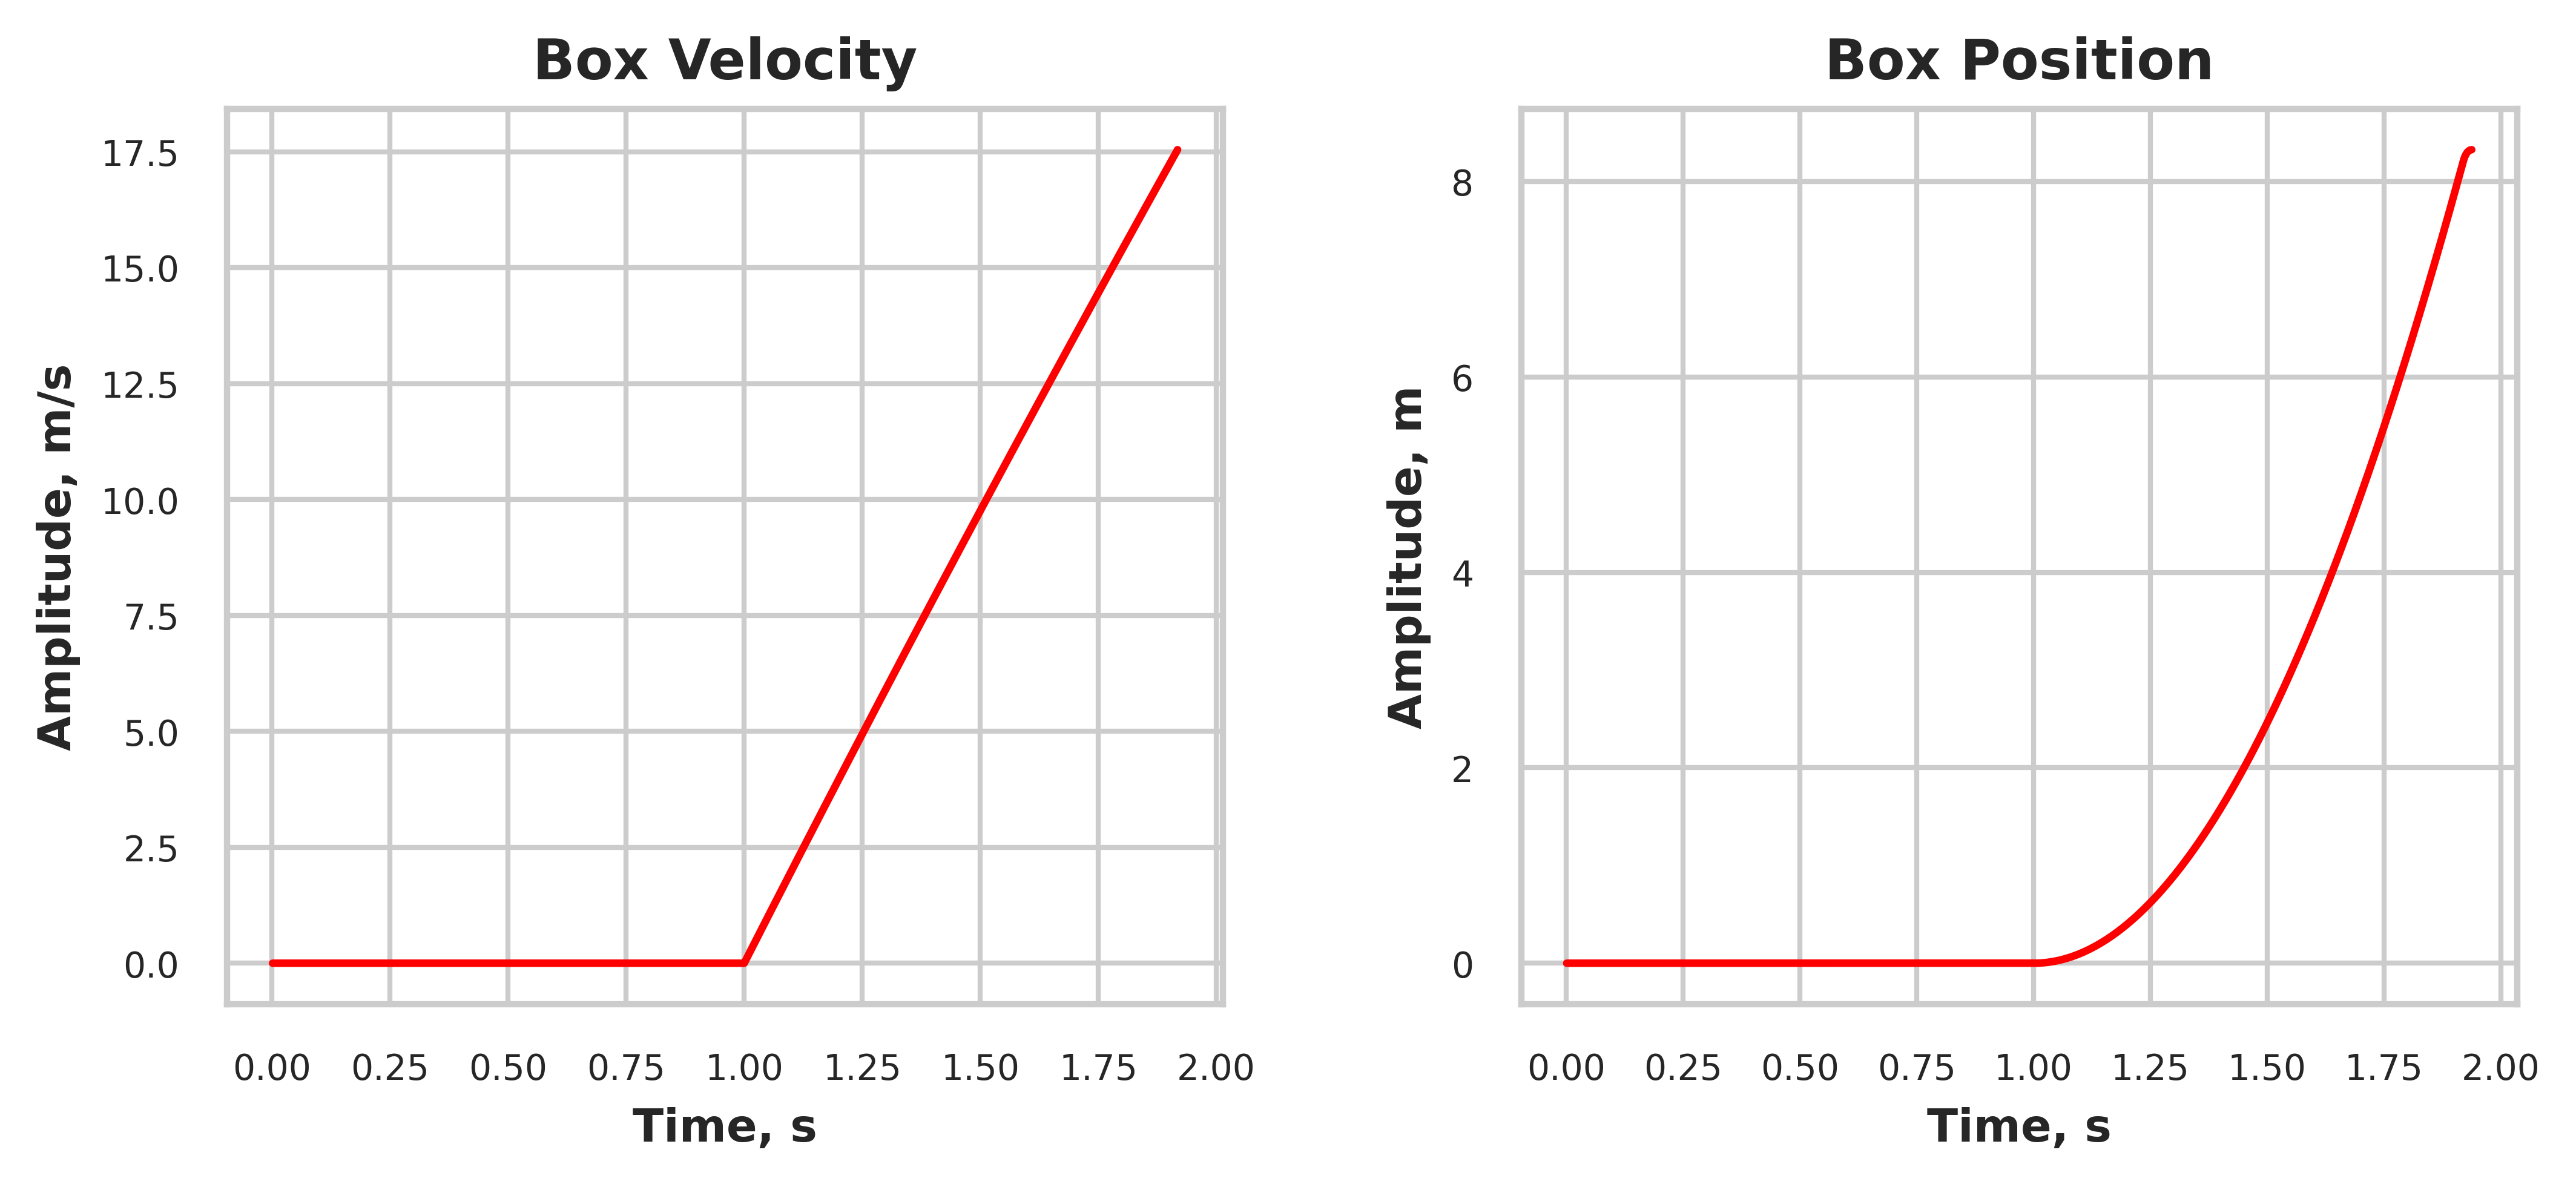

In [21]:
figsize = (width / dpi + 6, height / dpi + 2)
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi, sharex=False)
fig.subplots_adjust(wspace=0.3)

sns.lineplot(x=timevals_v, y=velocity, ax=ax[0], color="red")
ax[0].set_title('Box Velocity', weight="bold", fontsize=11)
ax[0].set_ylabel('Amplitude, m/s', weight="bold", fontsize=9)
ax[0].set_xlabel('Time, s', weight="bold", fontsize=9)
ax[0].tick_params(labelsize=7)

sns.lineplot(x=timevals_p, y=position, ax=ax[1], color="red")
ax[1].set_title('Box Position', weight="bold", fontsize=11)
ax[1].set_ylabel('Amplitude, m', weight="bold", fontsize=9)
ax[1].set_xlabel('Time, s', weight="bold", fontsize=9)
ax[1].tick_params(labelsize=7)

plt.savefig(f"../../output/newton_law_2.png", bbox_inches='tight')